In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

from darts.metrics import mape, mse, rmse, mae
from darts.models.filtering.moving_average_filter import MovingAverageFilter

from utils import print_metrics, plot_forecast, backtest, Dataset, TimeseriesExperiment

import pickle

import os

In [2]:
FILE_NAME = "data/electricity.txt"


def get_series_from_dataframe(dataframe, column_name):
    # consts
    TRAIN_DAYS = 60

    s = TimeSeries.from_dataframe(
        dataframe,
        time_col="ds",
        value_cols=column_name,
        freq=None,
        fill_missing_dates=True,
    )
    s = s.slice_n_points_before(s.end_time(), TRAIN_DAYS * 24 * 60)
    s = s.resample("1h", method="pad")

    ma_filter = MovingAverageFilter(12)
    s = ma_filter.filter(s)

    # save to txt file for layer use
    s.to_csv(FILE_NAME)

    return s


def get_series_from_dataframe_xgboost(df: pd.DataFrame) -> TimeSeries:
    df["Global_active_power"] = pd.to_numeric(
        df["Global_active_power"], errors="coerce"
    ).astype(np.float32)
    df["Global_reactive_power"] = pd.to_numeric(
        df["Global_reactive_power"], errors="coerce"
    ).astype(np.float32)
    df["Voltage"] = pd.to_numeric(df["Voltage"], errors="coerce").astype(np.float32)
    df["Global_intensity"] = pd.to_numeric(
        df["Global_intensity"], errors="coerce"
    ).astype(np.float32)
    df["Sub_metering_1"] = pd.to_numeric(df["Sub_metering_1"], errors="coerce").astype(
        np.float32
    )
    df["Sub_metering_2"] = pd.to_numeric(df["Sub_metering_2"], errors="coerce").astype(
        np.float32
    )
    df["Sub_metering_3"] = pd.to_numeric(df["Sub_metering_3"], errors="coerce").astype(
        np.float32
    )

    # fill NA values with the previous value
    df = df.ffill()

    return get_series_from_dataframe(df, "Global_active_power")


def load_electricity_data():
    # try to read TimeSeries object from electricity.txt file
    if os.path.exists(FILE_NAME):
        print(f"Reading from {FILE_NAME}")
        s = TimeSeries.from_csv(
            FILE_NAME, time_col="ds", value_cols="rolling_mean_12_Global_active_power"
        )
        return s

    df = pd.read_csv(
        "data/household_power_consumption.txt",
        sep=";",
        parse_dates={"ds": ["Date", "Time"]},
    )

    return get_series_from_dataframe_xgboost(df)

## Constants


In [3]:
HORIZONS = [1, 2, 3, 5, 7, 9, 10]

## Load dataset

In [4]:
Electricity_Dataset = Dataset(load_electricity_data(), "electricity")

Reading from data/electricity.txt


## Naive experiment

In [5]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)

In [6]:
for horizon in HORIZONS:
    if os.path.exists(
        f"results/{Electricity_Dataset.name}_{naive_model.__class__.__name__}_{horizon}.json"
    ):
        print(
            f"{Electricity_Dataset.name}_{naive_model.__class__.__name__}_{horizon}.json",
            "found - skipping...",
        )
        continue

    xgb_experiment = TimeseriesExperiment(
        naive_model,
        Electricity_Dataset,
        None,
        use_pretrained_model=True,
        forecast_horizon=horizon,
        retrain=True,
    )

    xgb_experiment.run()

electricity_NaiveSeasonal_1.json found - skipping...
electricity_NaiveSeasonal_2.json found - skipping...
electricity_NaiveSeasonal_3.json found - skipping...
electricity_NaiveSeasonal_5.json found - skipping...
electricity_NaiveSeasonal_7.json found - skipping...
electricity_NaiveSeasonal_9.json found - skipping...
electricity_NaiveSeasonal_10.json found - skipping...


## XGB Experiment

In [7]:
from darts.models.forecasting.xgboost import XGBModel

xgb_model = XGBModel(lags=24 * 7, output_chunk_length=100)

In [8]:
for horizon in HORIZONS:
    if os.path.exists(f'results/{Electricity_Dataset.name}_{xgb_model.__class__.__name__}_{horizon}.json'):
      print(f'{Electricity_Dataset.name}_{xgb_model.__class__.__name__}_{horizon}.json', 'found - skipping...')
      continue

    xgb_experiment = TimeseriesExperiment(
        xgb_model,
        Electricity_Dataset,
        [],
        use_pretrained_model=True,
        forecast_horizon=horizon,
        n_last_series_from_train_in_test=24 * 7,
    )

    xgb_experiment.run()

electricity_XGBModel_1.json found - skipping...
electricity_XGBModel_2.json found - skipping...
electricity_XGBModel_3.json found - skipping...
electricity_XGBModel_5.json found - skipping...
electricity_XGBModel_7.json found - skipping...
electricity_XGBModel_9.json found - skipping...
electricity_XGBModel_10.json found - skipping...


## Arima

In [9]:
# arima
from darts.models import ARIMA

model = ARIMA()

for horizon in HORIZONS:
    if os.path.exists(
        f"results/{Electricity_Dataset.name}_{model.__class__.__name__}_{horizon}.json"
    ):
        print(
            f"{Electricity_Dataset.name}_{model.__class__.__name__}_{horizon}.json",
            "found - skipping...",
        )
        continue

    experiment = TimeseriesExperiment(
        model,
        Electricity_Dataset,
        {"p": [1, 3, 5], "d": [1], "q": [0]},
        retrain=True,
        forecast_horizon=horizon,
    )

    experiment.run()

electricity_ARIMA_1.json found - skipping...
electricity_ARIMA_2.json found - skipping...
electricity_ARIMA_3.json found - skipping...
electricity_ARIMA_5.json found - skipping...
electricity_ARIMA_7.json found - skipping...
electricity_ARIMA_9.json found - skipping...
electricity_ARIMA_10.json found - skipping...


# Prophet

In [10]:
from darts.models import Prophet

prophet = Prophet()

for horizon in HORIZONS:
  if os.path.exists(f'results/{Electricity_Dataset.name}_{prophet.__class__.__name__}_{horizon}.json'):
    print(f'{Electricity_Dataset.name}_{prophet.__class__.__name__}_{horizon}.json', 'found - skipping...')
    continue

  prophet_experiment = TimeseriesExperiment(
    prophet,
    Electricity_Dataset,
    { },
    retrain=True,
    forecast_horizon=horizon,
  )

  prophet_experiment.run()

electricity_Prophet_1.json found - skipping...
electricity_Prophet_2.json found - skipping...
electricity_Prophet_3.json found - skipping...
electricity_Prophet_5.json found - skipping...
electricity_Prophet_7.json found - skipping...
electricity_Prophet_9.json found - skipping...
electricity_Prophet_10.json found - skipping...


# Light GBM

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


electricity_LightGBMModel_1.json found - skipping...


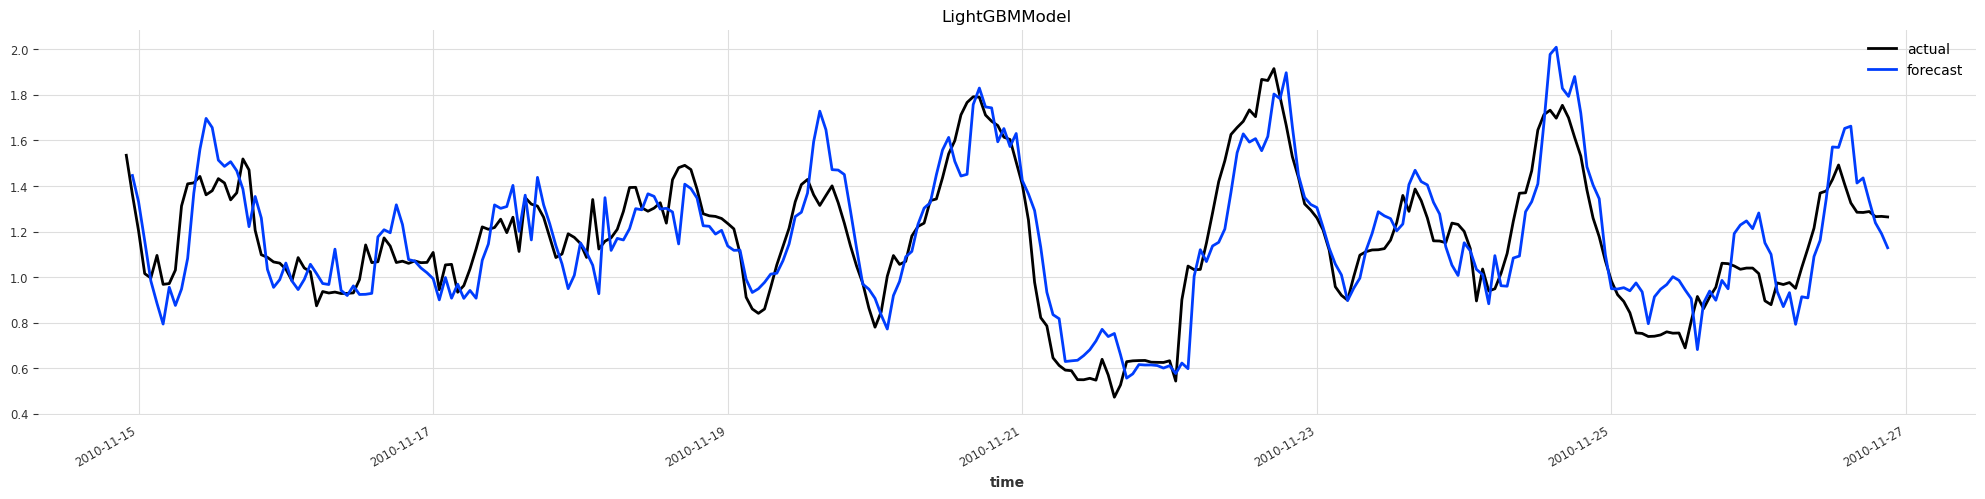

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


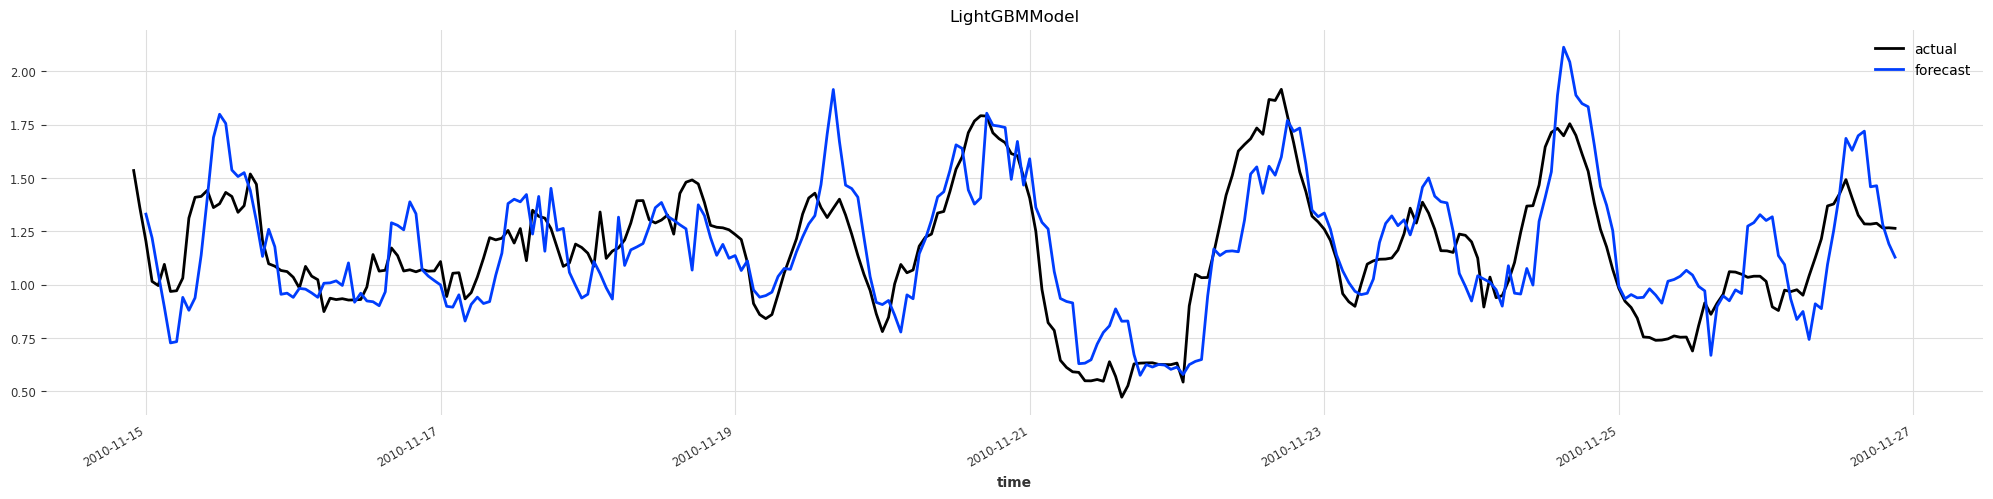

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


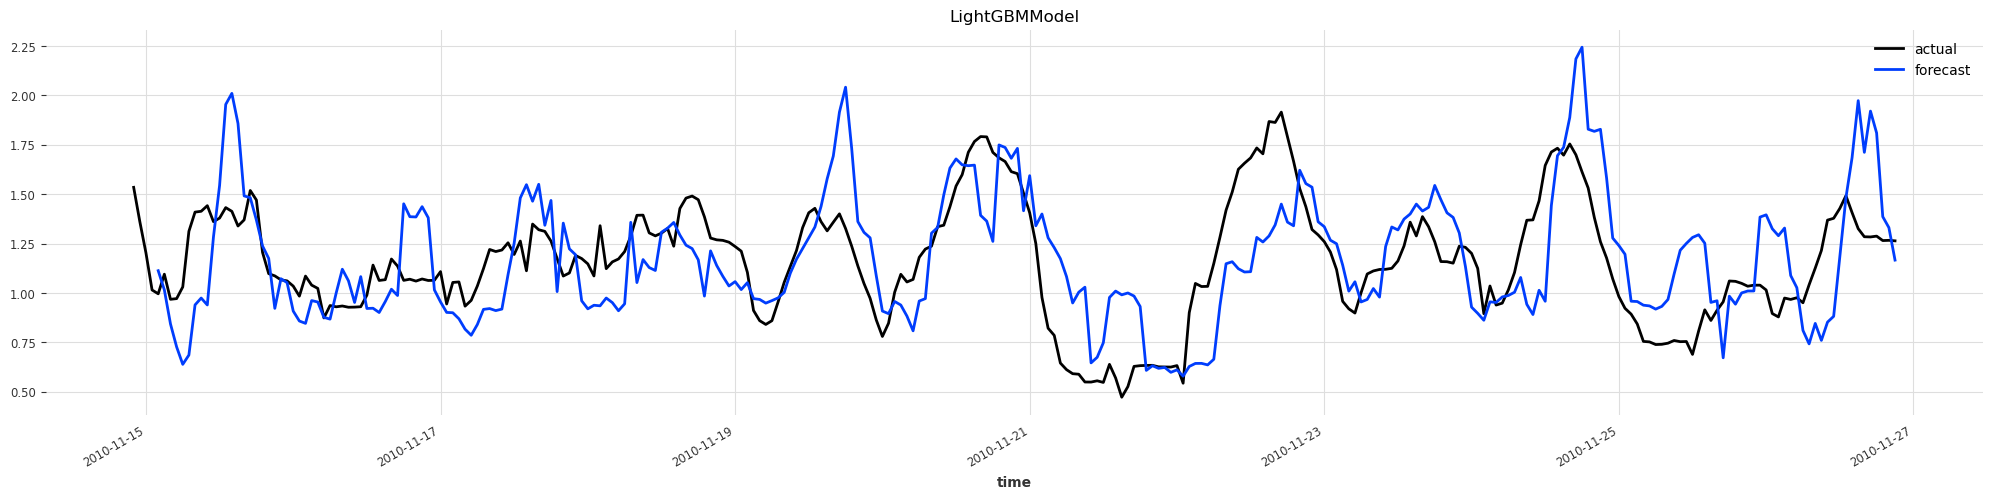

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


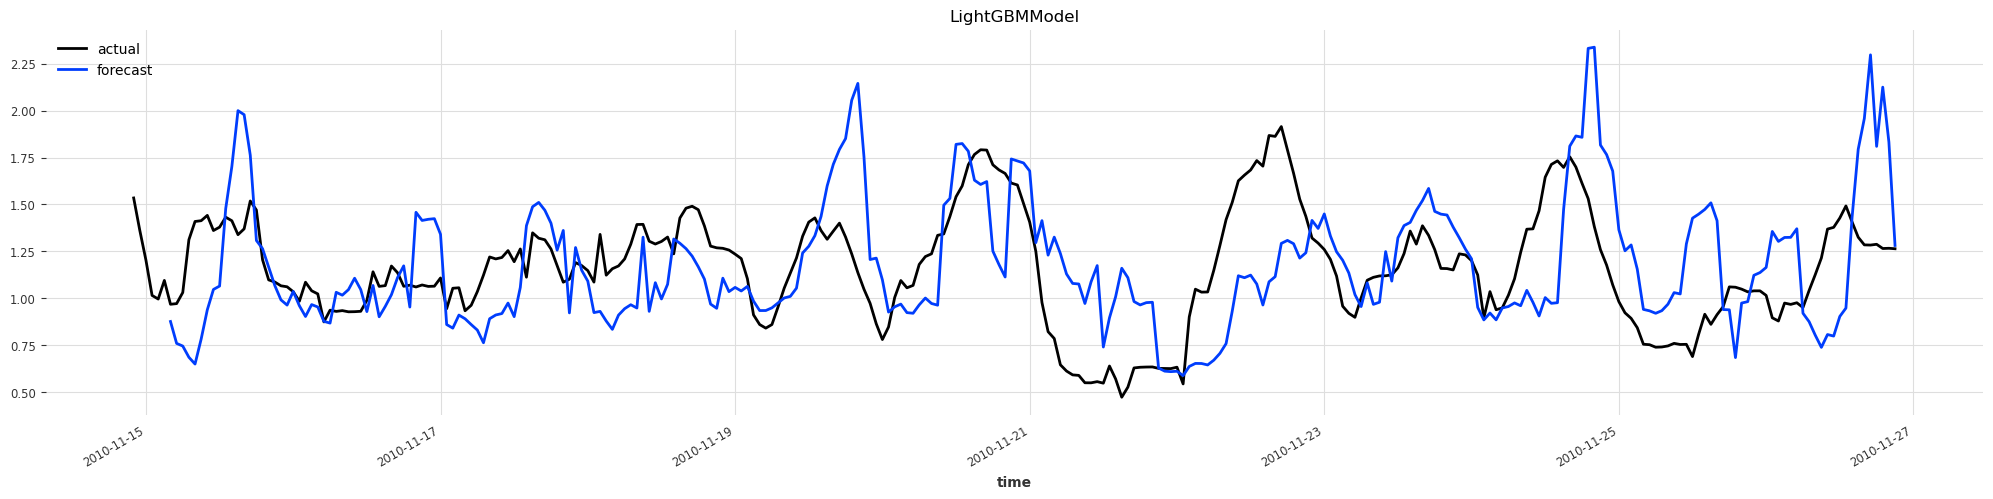

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


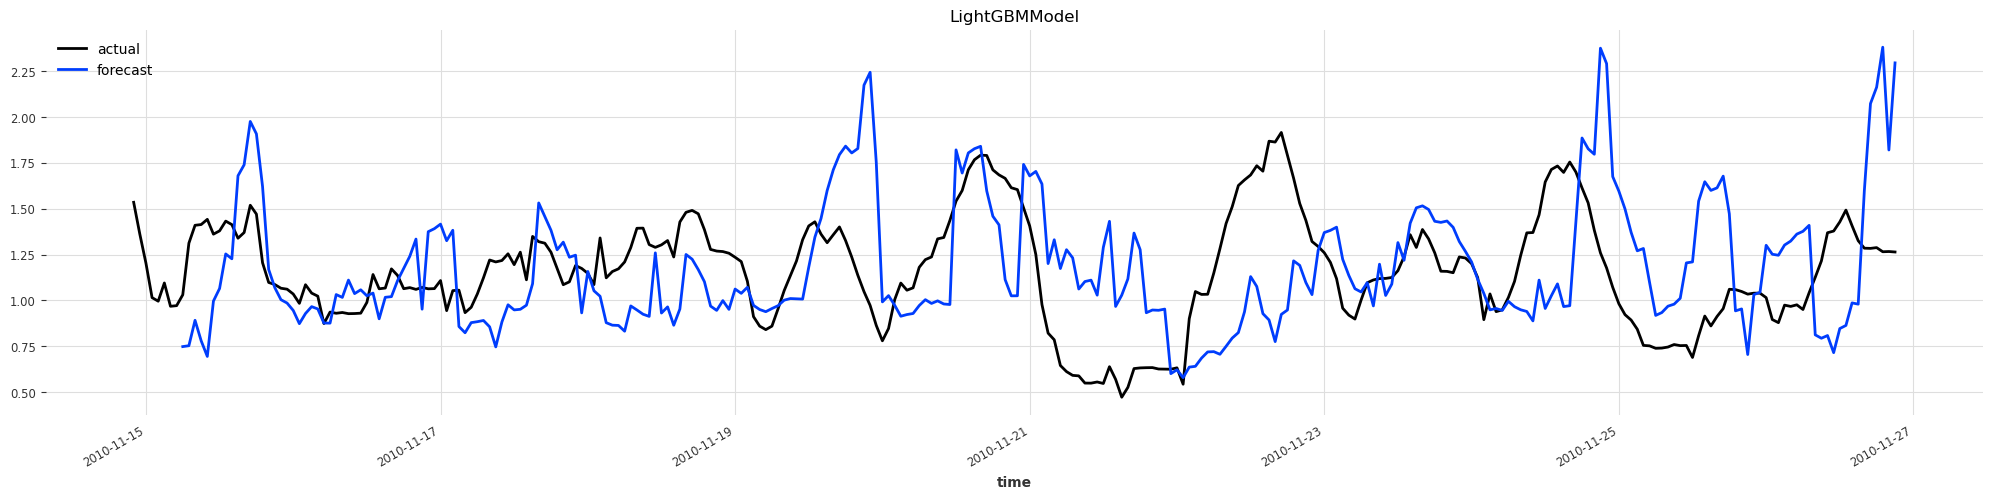

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


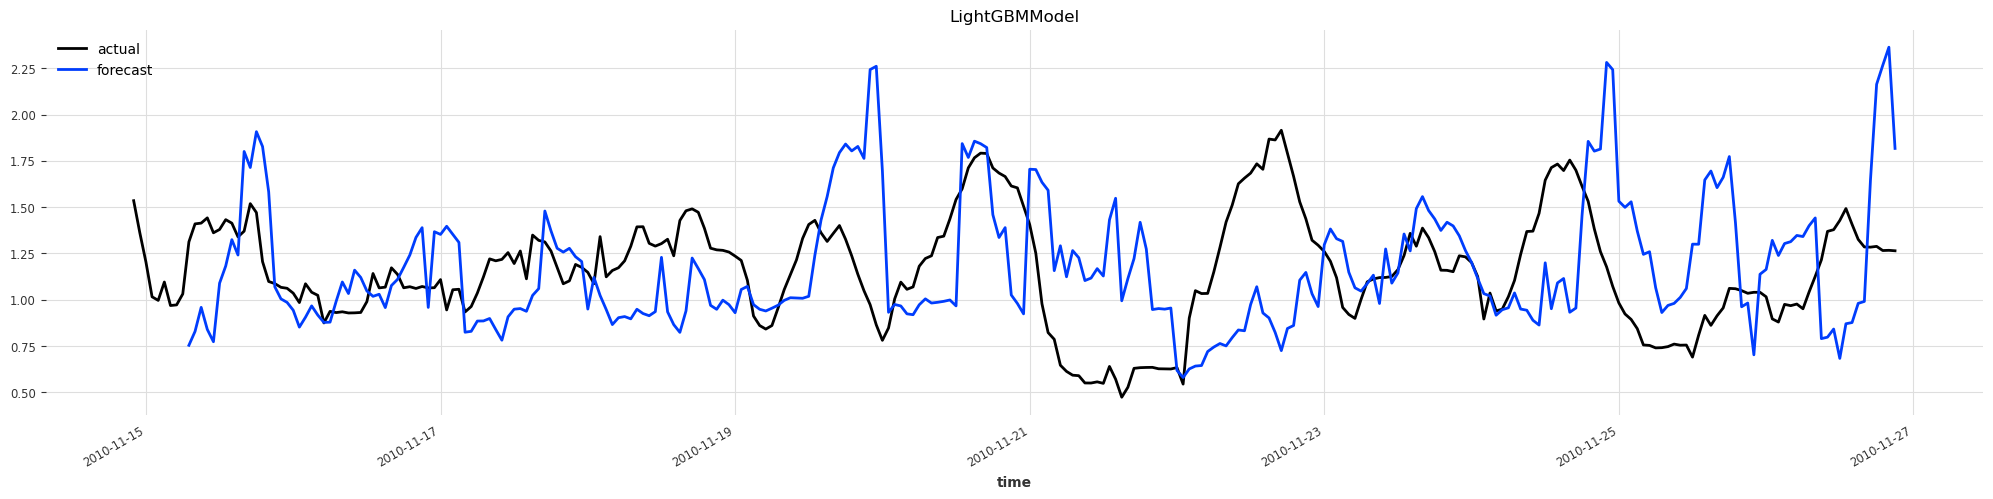

In [30]:
from darts.models import LightGBMModel

model_lgbm = LightGBMModel(lags=24,)

for horizon in HORIZONS:
    if os.path.exists(f'results/{Electricity_Dataset.name}_{model_lgbm.__class__.__name__}_{horizon}.json'):
        print(f'{Electricity_Dataset.name}_{model_lgbm.__class__.__name__}_{horizon}.json', 'found - skipping...')
        continue
    
    experiment = TimeseriesExperiment(
        model_lgbm,
        Electricity_Dataset,
        {
        'lags': [4, 7, 24],
        'max_depth': [3, 5, 7,  10, 24],
        },
        use_pretrained_model=True,
        forecast_horizon=horizon,
    )
    
    experiment.run()

# TFT

In [32]:
# we don't have future covariate data

# from darts.models import TFTModel

# for horizon in HORIZONS:
#     if os.path.exists(f"results/{Electricity_Dataset.name}_TFTModel_{horizon}.json"):
#         print(f"{Electricity_Dataset.name}_TFTModel_{horizon}.json", "found - skipping...")
#         continue

#     model = TFTModel(
#         input_chunk_length=24 * 7,
#         output_chunk_length=horizon,
#         n_epochs=100,
#         model_name="TFTModel",
#     )

#     tft_experiment = TimeseriesExperiment(
#         model,
#         Electricity_Dataset,
#         {},
#         retrain=True,
#         forecast_horizon=horizon,
#     )    

#     tft_experiment.run()
